# B. Data Preparation
- B.1 Collect Marathon Data from the Last Six Summer Olympics
- B.2 Transform ‘Birthplace’ and Obtain ISO-3 Country Codes
- B.3 Obtain Altitude Data for Birth Regions or Cities¶
- B.4 Collect Gross National Income (GNI) per Capita
- B.5 Collect Population Data
- B.6 Variable Transformation

In [2]:
import os
print(os.getcwd())

/Users/sungeun/Documents/2021-2025 Files/[JOB] 데이터분석 포트폴리오/06_Marathon


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

## B.1 Collect Marathon Data from the Last Six Summer Olympics

* Years: 2020 Tokyo, 2016 Rio, 2012 London, 2008 Beijing, 2004 Athens, 2000 Sydney *(Data from the 2024 Paris Olympics are not yet available and were therefore excluded.)*
* Source: Olympedia (https://www.olympedia.org)
* *Birth region altitude data are available, which can serve as a proxy for early-life environmental exposure (“live high”). Runner affiliation data are available—indicating their club, team, or sponsor—are available, but these may not reliably represent actual training locations, as many professional athletes train in multiple regions or countries.*


### Data Scraping

In [3]:
# Lists of olympic games to collect
tokyo_female = 19000740 #2020
tokyo_male = 19000437
rio_female = 359066
rio_male = 358639
london_female = 302003
london_male = 302377
beijing_female = 257631
beijing_male = 257229
athens_female = 66489
athens_male = 66095 
sydney_female = 65772
sydney_male = 65407 #2000

games = [
    {"location":"Tokyo", "year":"2020", "sex":"female", "url": tokyo_female},
    {"location":"Tokyo", "year":"2020", "sex":"male",   "url": tokyo_male},
    {"location":"Rio",   "year":"2016", "sex":"female", "url": rio_female},
    {"location":"Rio",   "year":"2016", "sex":"male",   "url": rio_male},
    {"location":"London","year":"2012", "sex":"female", "url": london_female},
    {"location":"London","year":"2012", "sex":"male",   "url": london_male},
    {"location":"Beijing","year":"2008","sex":"female", "url": beijing_female},
    {"location":"Beijing","year":"2008","sex":"male",   "url": beijing_male},
    {"location":"Athens","year":"2004","sex":"female", "url": sydney_female},
    {"location":"Athens","year":"2004","sex":"male",   "url": sydney_male},
    {"location":"Sydney","year":"2000","sex":"female", "url": sydney_female},
    {"location":"Sydney","year":"2000","sex":"male",   "url": sydney_male},
]

In [5]:
# Scrap olympic data
base_url = "https://www.olympedia.org"

all_data = []

for game in games:
    location = game['location']
    year = int(game['year'])
    sex = game['sex']
    url = game['url']
    
    full_url = base_url + "/results/" + str(url)
    response = requests.get(full_url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    table = soup.find("table", {"class": "table table-striped"})
    if not table:
        continue
    
    for row in table.find_all("tr"):
        columns = row.find_all("td")
        if len(columns) >= 5:
            position = columns[0].text.strip()
            if position == "DNF" or position == "DNS" or position == "DQ":
                continue
            position = int(position)
            
            # Competitor name & profile link
            competitor_tag = columns[2].find("a")
            competitor = competitor_tag.text.strip() if competitor_tag else columns[2].text.strip()
            competitor_url = base_url + competitor_tag['href'] if competitor_tag else None
            
            noc = columns[3].find("a").text.strip() if columns[3].find("a") else columns[3].text.strip()
            time = columns[4].text.strip()
            
            # Default biodata values
            birth_date, birth_place, height, weight, affiliations = None, None, None, None, None
            
            # Go into competitor’s page if link exists
            if competitor_url:
                comp_resp = requests.get(competitor_url)
                comp_soup = BeautifulSoup(comp_resp.content, "html.parser")
                
                biodata_table = comp_soup.find("table", {"class": "biodata"})
                if biodata_table:
                    for tr in biodata_table.find_all("tr"):
                        th = tr.find("th").text.strip() if tr.find("th") else ""
                        td = tr.find("td").text.strip() if tr.find("td") else ""
                        if th == "Born":
                            if " in " in td:
                                parts = td.split(" in ", 1)   # split into 2 parts max
                                birth_date = parts[0].strip()
                                birth_place = parts[1].strip()
                            else:
                                born_date = td.strip()
                                birth_place = None
                        elif th == "Measurements":
                            if "/" in td:
                                parts = td.split("/",1)
                                height = parts[0].strip()
                                weight = parts[1].strip()
                            else:
                                measurements = td.strip()
                            
                        elif th == "Affiliations":
                            affiliations = td
            
            all_data.append([
                year, location, sex, position, competitor, noc, time,
                birth_date, birth_place, height, weight, affiliations
            ])

# Make DataFrame
df_all = pd.DataFrame(
    all_data,
    columns=["year","location","sex","rank","name","country","time",
             "birthdate","birthplace","height","weight","affiliation"]
)

print(df_all.shape) #should be 73 for 2020 female marathon
df_all.head()

(1005, 12)


,year,location,sex,rank,name,country,time,birthdate,birthplace,height,weight,affiliation
0,2020,Tokyo,female,1,Peres Jepchirchir,KEN,2-27:20,None,None,None,None,None
1,2020,Tokyo,female,2,Brigid Kosgei,KEN,2-27:36,20 February 1994,"Kapsowar, Elgeyo-Marakwet (KEN)",None,None,None
2,2020,Tokyo,female,3,Molly Seidel,USA,2-27:46,12 July 1994,"Brookfield, Wisconsin (USA)",165 cm,52 kg,None
3,2020,Tokyo,female,4,Roza Dereje,ETH,2-28:38,None,None,None,None,None
4,2020,Tokyo,female,5,Volha Mazuronak,BLR,2-29:06,14 April 1989,"Quaraghandy, Quaraghandy (KAZ)",165 cm,49 kg,Minsk Region


In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         1005 non-null   int64 
 1   location     1005 non-null   object
 2   sex          1005 non-null   object
 3   rank         1005 non-null   int64 
 4   name         1005 non-null   object
 5   country      1005 non-null   object
 6   time         1005 non-null   object
 7   birthdate    877 non-null    object
 8   birthplace   877 non-null    object
 9   height       897 non-null    object
 10  weight       897 non-null    object
 11  affiliation  587 non-null    object
dtypes: int64(2), object(10)
memory usage: 94.3+ KB


In [7]:
df_all.to_csv("Olympic_marathon_2000-2020.csv", index=False)

In [98]:
df_raw1 = df_all.copy()

In [5]:
df_raw1 = pd.read_csv("0. Olympic_marathon_2000-2020.csv")

### Data Cleaning and Reformatting

In [6]:
# ---- 1. Convert "Time" to minutes ----
# Example: "2-27:20" means 2 hours, 27 minutes, 20 seconds
def time_to_minutes(t):
    try:
        if "-" in t:
            hours, rest = t.split("-", 1)
            minutes, seconds = rest.split(":")
            total_minutes = int(hours) * 60 + int(minutes) + int(seconds)/60
            return round(total_minutes, 2)
        elif ":" in t:  # if only mm:ss format
            minutes, seconds = t.split(":")
            return round(int(minutes) + int(seconds)/60, 2)
    except:
        return None
df_raw1["time_m"] = df_raw1["time"].apply(time_to_minutes)


# ---- 2. Convert Birthdate to YYYY-MM-DD ----
df_raw1["birthdate"] = pd.to_datetime(df_raw1["birthdate"], errors="coerce").dt.strftime("%Y-%m-%d")

# ---- 3. Clean Height and Weight ----
# Remove "cm" and "kg" units from Height and Weight
df_raw1["height"] = df_raw1["height"].str.replace("cm", "", regex=False).str.strip()
df_raw1["weight"] = df_raw1["weight"].str.replace("kg", "", regex=False).str.strip()

# Optionally convert to numeric (if you want numbers instead of strings)
df_raw1["height"] = pd.to_numeric(df_raw1["height"], errors="coerce")
df_raw1["weight"] = pd.to_numeric(df_raw1["weight"], errors="coerce")


### Imputing Missing Birthplaces
Missing birthplace information was filled manually using additional reliable online sources.

In [7]:
# Fill the missing birthplace that I found manually
birth_to_fill = {
    "Peres Jepchirchir": {
        "birthplace": "Turbo (KEN)",
        "birthdate": "1993-09-27",
    },
    "Mao Ichiyama": {
        "birthplace": "Izumi, Kagoshima Prefecture (JPN)",
        "birthdate": "1997-05-29",
    },
    "Gerda Steyn": {
        "birthplace": "Bothaville, Free State (ZAF)",
        "birthdate": "1990-03-03",
    },
    "Neheng Khatala": {
        "birthplace": "Maseru (LSO)",
        "birthdate": "1992-07-02",
    },
    "Honami Maeda": {
        "birthplace": "Amagasaki, Hyogo Prefecture (JPN)",
        "birthdate": "1996-07-17",
    },
    "Choi Gyeong-Seon": {
        "birthplace": "Gyeongju (KOR)",
        "birthdate": "1992-03-16",
    }}

In [8]:
for name, birth in birth_to_fill.items():
    df_raw1.loc[df_raw1["name"] == name, "birthplace"] = birth["birthplace"]
    df_raw1.loc[df_raw1["name"] == name, "birthdate"] = birth["birthdate"]
    
df_raw1[df_raw1["birthplace"].isna()].shape

(122, 13)

In [67]:
df_raw2 = df_raw1.copy()

## B.2 Transform ‘Birthplace’ and Obtain ISO-3 Country Codes
### Extract IOC Code
IOC codes included in the birthplace field were transferred to a separate column for clarity.

In [68]:
# df_raw2[df_raw2["birthplace"].isna()]
df_raw2[df_raw2["birthplace"].str.contains("\?", na=False)]["birthplace"].unique()

array(['?, Nandi (KEN)', '?, Dornod (MGL)', '?, Baringo (KEN)', '? (ETH)',
       '?, Jalisco (MEX)', '?, Chiriquí (PAN)', '? (KEN)',
       '?, Ömnögovi (MGL)', '?, Trans-Nzoia (KEN)', '? (KAZ)',
       '?, Laikipia (KEN)', '? (TPE)', '?, Govi-Altai (MGL)', '? (RWA)',
       '? (MRI)', '?, Shandong (CHN)', '? (ERI)', '?, Hwanghaenam (PRK)',
       '?, Jeollanam (KOR)', '?, Tabora (TAN)', '?, Chungcheongnam (KOR)',
       '? (PRK)', '?, Apurímac (PER)', '?, Yunnan (CHN)',
       '?, Gangwon (KOR)', '?, Zhambyl (KAZ)', '?, Stung Treng (CAM)',
       '? (SMR)', '?, Pohnpei (FSM)'], dtype=object)

In [69]:
# ---- Extract Country Code from Birthplace ----
import re

def extract_country(place):
    if pd.isna(place):
        return None
    match = re.search(r"\((\w{3})\)", place)  # look for (KEN)
    if match:
        return match.group(1)
    return None

df_raw2["birth_country"] = df_raw2["birthplace"].apply(extract_country)
# Remove the country code part from Birthplace
df_raw2["birthplace"] = df_raw2["birthplace"].str.replace(r"\s*\(\w{3}\)$", "", regex=True).str.strip()
# Remove "?," but keep "?" if it's not followed by text 
df_raw2["birthplace"] = df_raw2["birthplace"].str.replace(r"^\?,\s*", '', regex=True)
# Replace '?' or None with NaN in Birthplace
df_raw2["birthplace"] = df_raw2["birthplace"].replace("?", np.nan)
df_raw2["birthplace"] = df_raw2["birthplace"].replace("Unknown", np.nan)

df_raw2["birthplace"].isna().sum()

150

In [70]:
df_raw2["birth_country"].isna().sum()

122

### Impute Missing Birth Country
Missing birth country values were imputed using the athlete’s representing country. In most cases, missing birthplace information corresponded to instances where the birth and representing countries were the same, with only the regional details missing.

In [71]:
df_raw2["birth_country"] = df_raw2["birth_country"].fillna(df_raw2["country"])
df_raw2["birth_country"].isna().sum()

0

### Convert IOC to ISO-3 Codes
IOC country codes were converted to ISO-3 codes in a new column. The ISO-3 format facilitates integration with external datasets such as World Bank indicators. 

In [72]:
df_raw2.head(3)

,year,location,sex,rank,name,country,time,birthdate,birthplace,height,weight,affiliation,time_m,birth_country
0,2020,Tokyo,female,1,Peres Jepchirchir,KEN,2-27:20,1993-09-27,Turbo,NaN,NaN,NaN,147.33,KEN
1,2020,Tokyo,female,2,Brigid Kosgei,KEN,2-27:36,1994-02-20,"Kapsowar, Elgeyo-Marakwet",NaN,NaN,NaN,147.60,KEN
2,2020,Tokyo,female,3,Molly Seidel,USA,2-27:46,1994-07-12,"Brookfield, Wisconsin",165.0,52.0,NaN,147.77,USA


In [73]:
# Convert IOC code to ISO-3 including IOC codes that were not found in country_converter
import country_converter as coco

manual_converter = {
    "ZAF": "ZAF",   # South Africa
    "LSO": "LSO",   # Lesotho
    "GUE": "GGY",   # Guernsey (special case, not IOC official)
}

def ioc_to_iso3(iso_code):
    if iso_code is None or pd.isna(iso_code): # skip None / NaN values
        return None
    if iso_code in manual_converter:
        return manual_converter[iso_code]
    try:
        country = coco.convert(names=iso_code, src="IOC", to="ISO3")
        if country:
            return country
    except Exception as e:
        print(f"Error converting code '{iso_code}': {e}")
    return None

df_raw2["birth_country_iso"] = df_raw2["birth_country"].map(ioc_to_iso3)
df_raw2["birth_country_iso"].isna().sum()

EOR not found in IOC


0

The IOC code EOR is used for the Refugee Olympic Team

### Create Full Country Name Column
A new variable, birth_country, was created by converting ISO-3 codes into full country names. The birthplace column was updated to include both region and country name information.

In [74]:
import pycountry

def iso_to_fullname(iso_code):
    if iso_code is None or pd.isna(iso_code): # skip None / NaN values
        return None
    try:
        return pycountry.countries.get(alpha_3=iso_code).name
    except:
        return None

df_raw2["birth_country_full"] = df_raw2["birth_country_iso"].map(iso_to_fullname)
df_raw2["birthplace"] = df_raw2["birthplace"] + ", " + df_raw2["birth_country_full"]
df_raw2["birthplace"].isna().sum() #150 before birth country transferred to a new column

150

In [75]:
df_raw2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                1005 non-null   int64  
 1   location            1005 non-null   object 
 2   sex                 1005 non-null   object 
 3   rank                1005 non-null   int64  
 4   name                1005 non-null   object 
 5   country             1005 non-null   object 
 6   time                1005 non-null   object 
 7   birthdate           883 non-null    object 
 8   birthplace          855 non-null    object 
 9   height              897 non-null    float64
 10  weight              897 non-null    float64
 11  affiliation         587 non-null    object 
 12  time_m              1005 non-null   float64
 13  birth_country       1005 non-null   object 
 14  birth_country_iso   1005 non-null   object 
 15  birth_country_full  1004 non-null   object 
dtypes: flo

In [76]:
df_raw3 = df_raw2.copy()

## B.3 Obtain Altitude Data for Birth Regions or Cities
**Assumption**: Athletes are assumed to have spent sufficient time in their birth regions for local altitude to influence their physiological adaptation (e.g., through long-term residence or physical activity at high elevation).

In [ ]:
# !pip install geopy

In [77]:
import requests
from geopy.geocoders import Nominatim
import time

# Initialize geolocator
geolocator = Nominatim(user_agent="altitude_lookup")

altitude_cache = {} # Cache dictionary for repeated request

def get_altitude(place_name):
    if place_name is None or pd.isna(place_name): # skip None / NaN values
        return None
    
    if place_name in altitude_cache:
        return altitude_cache[place_name]
    try:
        # Step 1: Geocode place to lat/lon
        location = geolocator.geocode(place_name)
        if not location:
            altitude_cache[place_name] = None
            return None
        
        lat, lon = location.latitude, location.longitude
        
        # Step 2: Call Open-Elevation API
        url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}"
        r = requests.get(url).json()
        elevation = r['results'][0]['elevation']
        if elevation == 0:
            elevation = None
        
        result = {
        "latitude": lat,
        "longitude": lon,
        "elevation_m": elevation # in meters
        }
        
        altitude_cache[place_name] = result
        return result

    except Exception as e:
        print(f"Request error: {e}")
        return None

In [78]:
# Apply function with a delay to respect API limits
latitude, longitude, altitude = [],[],[]

for place in df_raw3["birthplace"]:
    result = get_altitude(place)
    if result is not None:
        latitude.append(result['latitude'])
        longitude.append(result['longitude'])
        altitude.append(result['elevation_m'])
    else:
        latitude.append(None)
        longitude.append(None)
        altitude.append(None)
    time.sleep(1)  # avoid rate limiting

# Add as new column
df_raw3["latitude"] = latitude
df_raw3["longitude"] = longitude
df_raw3["altitude"] = altitude

In [79]:
df_raw3.to_csv("Marathon_alt.csv", index=False)

In [118]:
df_raw4 = df_raw3.copy()
# df_raw4 = pd.read_csv("Marathoners_altitude_api.csv")

In [111]:
df_raw4.head()

,year,location,sex,rank,name,country,time,birthdate,birthplace,height,weight,affiliation,time_m,birth_country,birth_country_iso,birth_country_full,latitude,longitude,altitude
0,2020,Tokyo,female,1,Peres Jepchirchir,KEN,2-27:20,1993-09-27,"Turbo, Kenya",NaN,NaN,NaN,147.33,KEN,KEN,Kenya,0.597513,35.098475,1891.0
1,2020,Tokyo,female,2,Brigid Kosgei,KEN,2-27:36,1994-02-20,"Kapsowar, Elgeyo-Marakwet, Kenya",NaN,NaN,NaN,147.60,KEN,KEN,Kenya,0.980103,35.560270,2296.0
2,2020,Tokyo,female,3,Molly Seidel,USA,2-27:46,1994-07-12,"Brookfield, Wisconsin, United States",165.0,52.0,NaN,147.77,USA,USA,United States,43.061558,-88.126068,271.0
3,2020,Tokyo,female,4,Roza Dereje,ETH,2-28:38,NaN,NaN,NaN,NaN,NaN,148.63,ETH,ETH,Ethiopia,NaN,NaN,NaN
4,2020,Tokyo,female,5,Volha Mazuronak,BLR,2-29:06,1989-04-14,"Quaraghandy, Quaraghandy, Kazakhstan",165.0,49.0,Minsk Region,149.10,KAZ,KAZ,Kazakhstan,NaN,NaN,NaN


### Fill Missing Coordinates
For 80 missing cases, longitude and latitude were manually obtained using the GPS Coordinates website(https://www.gps-coordinates.net/). The API provided inconsistent results, so data were verified and merged manually.

In [112]:
df_raw4[df_raw4["latitude"].isna()].shape

(271, 19)

In [113]:
df_raw4[df_raw4["latitude"].isna()].head()

,year,location,sex,rank,name,country,time,birthdate,birthplace,height,weight,affiliation,time_m,birth_country,birth_country_iso,birth_country_full,latitude,longitude,altitude
3,2020,Tokyo,female,4,Roza Dereje,ETH,2-28:38,NaN,NaN,NaN,NaN,NaN,148.63,ETH,ETH,Ethiopia,NaN,NaN,NaN
4,2020,Tokyo,female,5,Volha Mazuronak,BLR,2-29:06,1989-04-14,"Quaraghandy, Quaraghandy, Kazakhstan",165.0,49.0,Minsk Region,149.10,KAZ,KAZ,Kazakhstan,NaN,NaN,NaN
10,2020,Tokyo,female,11,Helalia Johannes,NAM,2-31:22,1980-08-13,"Oshali, Oshana, Namibia",165.0,46.0,Namibian Defence Force [Namibia],151.37,NAM,NAM,Namibia,NaN,NaN,NaN
15,2020,Tokyo,female,16,Immaculate Chemutai,UGA,2-32:23,NaN,NaN,NaN,NaN,NaN,152.38,UGA,UGA,Uganda,NaN,NaN,NaN
23,2020,Tokyo,female,24,Failuna Matanga,TAN,2-33:58,1992-10-28,"Kondoa, Dodoma, Tanzania, United Republic of",NaN,NaN,NaN,153.97,TAN,TZA,"Tanzania, United Republic of",NaN,NaN,NaN


In [119]:
from rapidfuzz import process

fill_alt = pd.read_csv("2. Marathon_alt_manual.csv")
lat_lookup = {}
lon_lookup = {}

choices = fill_alt["Birthplace_full"].unique()

for bp in df_raw4["birthplace"].unique():
    result = process.extractOne(bp, choices)
    if result is None:
        continue  # skip if no match found
    match, score, _ = result
    if score > 70:  # set similarity threshold
        row = fill_alt.loc[fill_alt["Birthplace_full"] == match].iloc[0]
        lat_lookup[bp] = row["Latitude"]
        lon_lookup[bp] = row["Longitude"]

# Overwrite missing latitude/longitude
df_raw4["latitude"] = df_raw4.apply(
    lambda row: lat_lookup.get(row["birthplace"], row["latitude"]), axis=1)
df_raw4["longitude"] = df_raw4.apply(
    lambda row: lon_lookup.get(row["birthplace"], row["longitude"]), axis=1)

In [120]:
df_raw4[df_raw4["latitude"].isna()].shape

(152, 19)

In [122]:
mask = df_raw4["birthplace"].notna() & df_raw4["latitude"].isna()
rows = df_raw4[mask]
rows

,year,location,sex,rank,name,country,time,birthdate,birthplace,height,weight,affiliation,time_m,birth_country,birth_country_iso,birth_country_full,latitude,longitude,altitude
814,2004,Athens,male,17,João N'Tyamba,ANG,2-16:43,1968-03-20,"Zimbambi, Huíla, Angola",178.0,60.0,NaN,136.72,ANG,AGO,Angola,NaN,NaN,NaN
940,2000,Sydney,male,17,João N'Tyamba,ANG,2-16:43,1968-03-20,"Zimbambi, Huíla, Angola",178.0,60.0,NaN,136.72,ANG,AGO,Angola,NaN,NaN,NaN


In [123]:
rows["birthplace"].unique()

array(['Zimbambi, Huíla, Angola'], dtype=object)

In [124]:
df_raw4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                1005 non-null   int64  
 1   location            1005 non-null   object 
 2   sex                 1005 non-null   object 
 3   rank                1005 non-null   int64  
 4   name                1005 non-null   object 
 5   country             1005 non-null   object 
 6   time                1005 non-null   object 
 7   birthdate           883 non-null    object 
 8   birthplace          855 non-null    object 
 9   height              897 non-null    float64
 10  weight              897 non-null    float64
 11  affiliation         587 non-null    object 
 12  time_m              1005 non-null   float64
 13  birth_country       1005 non-null   object 
 14  birth_country_iso   1005 non-null   object 
 15  birth_country_full  1004 non-null   object 
 16  latitu

In [125]:
df_raw5 = df_raw4.copy()

### Retrieve Altitude Values
Altitude data were retrieved using geographic coordinates (latitude and longitude).

In [126]:
# Function to fetch altitude using lat/lon
def get_altitude_from_latlon(lat, lon):
    if lat is None or lon is None:
        return None
    try:
        url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}"
        r = requests.get(url).json()
        if "results" in r:
            return r["results"][0]["elevation"]
    except:
        return None
    return None

# Find rows with missing altitude
missing_alt = df_raw5[df_raw5["altitude"].isna()]

# Loop through them and update
for idx, row in missing_alt.iterrows():
    lat, lon = row["latitude"], row["longitude"]
    if pd.notna(lat) and pd.notna(lon):
        elevation = get_altitude_from_latlon(lat, lon)
        if elevation is not None:
            df_raw5.loc[idx, "altitude"] = elevation

In [127]:
df_raw5[df_raw5["altitude"].isna()].shape

(152, 19)

In [128]:
df_raw5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                1005 non-null   int64  
 1   location            1005 non-null   object 
 2   sex                 1005 non-null   object 
 3   rank                1005 non-null   int64  
 4   name                1005 non-null   object 
 5   country             1005 non-null   object 
 6   time                1005 non-null   object 
 7   birthdate           883 non-null    object 
 8   birthplace          855 non-null    object 
 9   height              897 non-null    float64
 10  weight              897 non-null    float64
 11  affiliation         587 non-null    object 
 12  time_m              1005 non-null   float64
 13  birth_country       1005 non-null   object 
 14  birth_country_iso   1005 non-null   object 
 15  birth_country_full  1004 non-null   object 
 16  latitu

In [129]:
df_raw5.to_csv("3. Marathon_alt_final.csv", index=False)

In [130]:
df_raw6 =df_raw5.copy()

### Add Country-Level Average Altitudes
Country-average altitude values were added to the dataset to compare within-country versus between-country variation. Country names that differed across sources (e.g., Wikipedia and World Bank) were standardized. For countries or territories not listed in standard datasets (e.g., Solomon Islands, Hong Kong, Puerto Rico, South Sudan, Timor-Leste, Liechtenstein, Saint Vincent and the Grenadines, Cabo Verde, and Micronesia), average elevations were obtained from Topographic Map(https://en-gb.topographic-map.com/).

In [74]:
# pip install lxml

In [45]:
from io import StringIO
url = "https://en.wikipedia.org/wiki/List_of_countries_by_average_elevation"

# Fetch page with headers (to avoid 403 forbidden)
headers = {"User-Agent": "Mozilla/5.0"}
html = requests.get(url, headers=headers).text

# Read tables
tables = pd.read_html(StringIO(html), header=[0, 1])  # read multi-level header
df_elevation = tables[0]

# Flatten the MultiIndex columns
df_elevation.columns = [col[1] if col[1] != " " else col[0] for col in df_elevation.columns]

# Now we have: ["Location", "m", "ft", "Ref"]
df_elevation = df_elevation.rename(columns={"Location": "country", "m": "country_altitude"})

# Keep only country + elevation (meters)
df_elevation = df_elevation[["country", "country_altitude"]]

# Clean elevation (remove commas and convert to float)
df_elevation["country_altitude"] = (
    df_elevation["country_altitude"] #altitude in meters
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)
df_elevation.head()

,country,country_altitude
0,World,840.0
1,Afghanistan,1884.0
2,Albania,708.0
3,Algeria,800.0
4,Andorra,1996.0


In [133]:
choices = df_elevation["country"].unique()
elevation_lookup = {}

for bp in df_raw6["birth_country_full"].dropna().unique():
    result = process.extractOne(bp, choices)
    if result is None:
        continue
    match, score, _ = result
    if score > 85:  # similarity threshold
        row = df_elevation.loc[df_elevation["country"] == match].iloc[0]
        elevation_lookup[bp] = row["country_altitude"]

# Map back to df_raw6
df_raw6["country_altitude"] = df_raw6["birth_country_full"].map(elevation_lookup)

In [134]:
df_raw6[df_raw6["country_altitude"].isna()]["birth_country_full"].unique()

array(['Czechia', 'Solomon Islands', None, 'Türkiye', 'Hong Kong',
       'Puerto Rico', 'Mauritius', 'Timor-Leste', 'Guernsey',
       'Liechtenstein', 'Guam', 'Cabo Verde', 'San Marino'], dtype=object)

In [135]:
missing_elevation_map = { # Average elevation in meters, obtained from Topographic Map
    None: None,
    'Czechia': 369,  
    'Solomon Islands': 7,  
    'Türkiye': 487, 
    'Hong Kong': 47,  
    'Puerto Rico': 21, 
    'Mauritius': 0,
    'Timor-Leste': 81, 
    'Guernsey': 18,  
    'Liechtenstein': 1080, 
    'Guam': 16,
    'Cabo Verde': 937,
    'San Marino': 268,
}

for country, elevation in missing_elevation_map.items():
    df_raw6.loc[df_raw6['birth_country_full'] == country, 'country_altitude'] = elevation

In [136]:
df_raw6["country_altitude"].isna().sum()

1

In [137]:
df_raw6[df_raw6["country_altitude"].isna()]["birth_country_full"].unique()

array([None], dtype=object)

In [138]:
df_raw6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                1005 non-null   int64  
 1   location            1005 non-null   object 
 2   sex                 1005 non-null   object 
 3   rank                1005 non-null   int64  
 4   name                1005 non-null   object 
 5   country             1005 non-null   object 
 6   time                1005 non-null   object 
 7   birthdate           883 non-null    object 
 8   birthplace          855 non-null    object 
 9   height              897 non-null    float64
 10  weight              897 non-null    float64
 11  affiliation         587 non-null    object 
 12  time_m              1005 non-null   float64
 13  birth_country       1005 non-null   object 
 14  birth_country_iso   1005 non-null   object 
 15  birth_country_full  1004 non-null   object 
 16  latitu

In [4]:
# df_raw6.to_csv("4. Marathon_alt_c_final.csv", index=False)
df_raw6 = pd.read_csv("4. Marathon_alt_c_final.csv")

In [71]:
df_raw7 = df_raw6.copy()

### Validation
Randomly selected rows were manually verified using FreeMapTools Elevation Finder(https://www.freemaptools.com/elevation-finder.htm) to ensure altitude accuracy.

In [146]:
# Randomly select 5 rows (change n=5 to however many you want)
sample_df = pd.read_csv("4. Marathoners_altitude_final2.csv")
sample = (
    sample_df.dropna(subset=["birthplace", "latitude", "longitude", "altitude"])
           .sample(n=10, random_state=42)
)

sample_e = sample[["birthplace", "latitude", "longitude", "altitude"]]
sample_e

,birthplace,latitude,longitude,altitude
511,"Nishinomiya, Hyogo, Japan",34.737775,135.341313,6.0
39,"Kfar Saba, HaMerkaz, Israel",32.175000,34.906940,59.0
211,"Sawarpada, Nashik, Maharashtra, India",19.997270,73.790960,582.0
199,"Zagreb, Grad Zagreb, Croatia",45.842641,15.962231,288.0
235,"Pacaembu, São Paulo, Brazil",-21.566243,-51.263311,418.0
215,"San Juan, San Juan, Argentina",-31.537091,-68.525180,642.0
568,"Camposampiero, Padova, Italy",45.571760,11.931929,26.0
352,"Yamakita, Kanagawa, Japan",35.360605,139.083834,107.0
300,"Chascomús, Provincia de Buenos Aires, Argentina",-35.578687,-58.013825,19.0
137,"Šiauliai, Šiauliai, Lithuania",55.923070,23.313912,128.0


In [147]:
locations = sample_e["birthplace"].unique()
locations_dict = {loc: None for loc in locations}
locations_dict

{'Nishinomiya, Hyogo, Japan': None,
 'Kfar Saba, HaMerkaz, Israel': None,
 'Sawarpada, Nashik, Maharashtra, India': None,
 'Zagreb, Grad Zagreb, Croatia': None,
 'Pacaembu, São Paulo, Brazil': None,
 'San Juan, San Juan, Argentina': None,
 'Camposampiero, Padova, Italy': None,
 'Yamakita, Kanagawa, Japan': None,
 'Chascomús, Provincia de Buenos Aires, Argentina': None,
 'Šiauliai, Šiauliai, Lithuania': None}

In [36]:
check_elevation = {
    'Nishinomiya, Hyogo, Japan': 12.5,
     'Kfar Saba, HaMerkaz, Israel': 56.2, 
     'Sawarpada, Nashik, Maharashtra, India': 575.7,
     'Zagreb, Grad Zagreb, Croatia': 280.6,
     'Pacaembu, São Paulo, Brazil': 417.4,
     'San Juan, San Juan, Argentina': 641.8,
     'Camposampiero, Padova, Italy': 24.0,
     'Yamakita, Kanagawa, Japan': 115.4,
     'Chascomús, Provincia de Buenos Aires, Argentina': 19.9,
     'Šiauliai, Šiauliai, Lithuania': 128.0}

In [37]:
# Make an explicit copy to avoid SettingWithCopyWarning
sample_e = sample_e.copy()

# for city, real_elevation in check_elevation.items():
#     sample_e.loc[sample_e["birthplace"]== city, "altitude_checked"] = real_elevation

#     # Compute difference between recorded altitude and checked altitude
# sample_e["diff_altitude"] = sample_e["altitude"] - sample_e["altitude_checked"]

# Map all values at once
sample_e["altitude_checked"] = sample_e["birthplace"].map(check_elevation)
sample_e["diff_altitude"] = sample_e["altitude"] - sample_e["altitude_checked"]

sample_e

,birthplace,latitude,longitude,altitude,altitude_checked,diff_altitude
552,"Nishinomiya, Hyogo, Japan",34.737775,135.341313,6.0,12.5,-6.5
41,"Kfar Saba, HaMerkaz, Israel",32.175000,34.906940,59.0,56.2,2.8
221,"Sawarpada, Nashik, Maharashtra, India",19.997270,73.790960,582.0,575.7,6.3
208,"Zagreb, Grad Zagreb, Croatia",45.842641,15.962231,288.0,280.6,7.4
247,"Pacaembu, São Paulo, Brazil",-21.566243,-51.263311,418.0,417.4,0.6
226,"San Juan, San Juan, Argentina",-31.537091,-68.525180,642.0,641.8,0.2
612,"Camposampiero, Padova, Italy",45.571760,11.931929,26.0,24.0,2.0
373,"Yamakita, Kanagawa, Japan",35.360605,139.083834,107.0,115.4,-8.4
313,"Chascomús, Provincia de Buenos Aires, Argentina",-35.578687,-58.013825,19.0,19.9,-0.9
144,"Šiauliai, Šiauliai, Lithuania",55.923070,23.313912,128.0,128.0,0.0


In [38]:
sample_e["diff_altitude"].mean()

0.3499999999999993

The difference are very minimal. So I can safely move on to next step.

## B.4 Collect Gross National Income (GNI) per Capita
**Rationale**: GNI per capita (Atlas method or PPP) is widely used by the World Bank to classify countries into income groups (Low, Lower-Middle, Upper-Middle, and High). Including this variable allows for controlling economic differences across countries.

**Source**: World Bank World Development Indicators (WDI).

On my mac, there was an issue with a corrupted package cache of wbdata. I was able to fix this issue by deleting ~/Library/Caches/wbdata/1.0.0/cache.db.

In [6]:
import wbdata
import datetime
import pycountry

# Define the indicator: GNI per capita, Atlas method (current US$)
indicator = {"NY.GNP.PCAP.CD": "GNI_per_capita"}

# Filter country codes
all_countries = wbdata.get_countries()
all_valid_codes = set([c['id'] for c in all_countries])
country_codes = df_raw7["birth_country_iso"].unique().tolist()
country_codes = [c for c in country_codes if c in all_valid_codes]

name_to_iso = {c['name']: c['id'] for c in all_countries}  # name -> ISO

years = [2000, 2004, 2008, 2012, 2016, 2020]

frames = []
for year in years:
    print(f"Fetching data for year {year}...")
    date = datetime.datetime(year, 1, 1)
    df = wbdata.get_dataframe(
        indicators=indicator,
        country=country_codes,
        date=date,
    ).reset_index()
    df['year'] = year
    df['country_iso'] = df['country'].map(name_to_iso)
    frames.append(df)

GNI_data = pd.concat(frames, ignore_index=True).sort_values(by=["country","year"])

GNI_data.head()

Fetching data for year 2000...
Fetching data for year 2004...
Fetching data for year 2008...
Fetching data for year 2012...
Fetching data for year 2016...
Fetching data for year 2020...


,country,GNI_per_capita,year,country_iso
26,Algeria,1600.0,2000,DZA
143,Algeria,2440.0,2004,DZA
260,Algeria,4430.0,2008,DZA
377,Algeria,5630.0,2012,DZA
494,Algeria,4920.0,2016,DZA


In [45]:
GNI_data.loc[
    GNI_data["country"].str.contains("Somalia", na=False) & GNI_data["country_iso"].isna(),
    "country_iso"
] = "SOM"

In [47]:
GNI_data.to_csv("5. GNI_data.csv", index=False)
# GNI_data = pd.read_csv("5. GNI_data.csv")

In [70]:
# Rename columns in GNI_data for consistency
GNI_data_iso = GNI_data.drop(columns="country")
GNI_data_iso = GNI_data_iso.rename(columns={"GNI_per_capita": "gni_per_capita", "country_iso":"birth_country_iso"})
GNI_data_iso.head()

,gni_per_capita,year,birth_country_iso
0,1600.0,2000,DZA
1,2440.0,2004,DZA
2,4430.0,2008,DZA
3,5630.0,2012,DZA
4,4920.0,2016,DZA


In [72]:
# Merge two datasets
df_raw7 = df_raw7.merge(GNI_data_iso, how="left", on=["birth_country_iso", "year"])
df_raw7.head(3)

,year,location,sex,rank,name,country,time,birthdate,birthplace,height,...,affiliation,time_m,birth_country,birth_country_iso,birth_country_full,latitude,longitude,altitude,country_altitude,gni_per_capita
0,2020,Tokyo,female,1,Peres Jepchirchir,KEN,2-27:20,1993-09-27,"Turbo, Kenya",NaN,...,NaN,147.33,KEN,KEN,Kenya,0.597513,35.098475,1891.0,762.0,1910.0
1,2020,Tokyo,female,2,Brigid Kosgei,KEN,2-27:36,1994-02-20,"Kapsowar, Elgeyo-Marakwet, Kenya",NaN,...,NaN,147.60,KEN,KEN,Kenya,0.980103,35.560270,2296.0,762.0,1910.0
2,2020,Tokyo,female,3,Molly Seidel,USA,2-27:46,1994-07-12,"Brookfield, Wisconsin, United States",165.0,...,NaN,147.77,USA,USA,United States,43.061558,-88.126068,271.0,760.0,64940.0


In [73]:
# GNI_data[(GNI_data["Year"]==2020) & (GNI_data["Birth_country_full"]=="South Korea")]
# GNI_data_iso[GNI_data_iso["birth_country_iso"]=="SOM"]
codes_to_check = df_raw7[df_raw7["gni_per_capita"].isna()]["birth_country_iso"].unique()
rows = GNI_data_iso[GNI_data_iso['birth_country_iso'].isin(codes_to_check)]
rows

,gni_per_capita,year,birth_country_iso
6,NaN,2000,AND
7,NaN,2004,AND
8,NaN,2008,AND
9,NaN,2012,AND
10,NaN,2016,AND
11,42450.0,2020,AND
174,310.0,2000,ERI
175,350.0,2004,ERI
176,440.0,2008,ERI
177,NaN,2012,ERI


In [74]:
mask = df_raw7["birth_country_iso"].notna() & df_raw7["gni_per_capita"].isna()
rows = df_raw7[mask]
rows["birth_country_iso"].unique()

array(['ERI', 'not found', 'PRK', 'TWN', 'SSD', 'VEN', 'GGY', 'AND',
       'LIE', 'GUM', 'SMR'], dtype=object)


- Taiwan, Somalia, North Korea: wikipedia 2024 gni per capita (https://en.wikipedia.org/wiki/List_of_countries_by_GNI_(nominal)_per_capita)
- Guam, Guernsey: Use the parent economy’s GNI (e.g., Guam → United States, Guernsey → United Kingdom)
- Others: available gni closest to the year from GNI dataset 


In [75]:
# Fill available gni closest to the year or data from wikipedia
fill_missing_gni = {"AND": 42460.0, "ERI": 440.0, "LIE": 121890.0,
                    "SMR": 40570.0, "SSD": 800.0, "VEN": 12620.0,
                   "TWN": 35360.0, "PRK":650.0,}
df_raw7["gni_per_capita"] = df_raw7["gni_per_capita"].fillna(
    df_raw7["birth_country_iso"].map(fill_missing_gni)
)

In [76]:
# Use the parent economy's GNI
usa_gni = GNI_data_iso.loc[GNI_data_iso["birth_country_iso"] == "USA"].set_index("year")["gni_per_capita"].to_dict()
gbr_gni = GNI_data_iso.loc[GNI_data_iso["birth_country_iso"] == "GBR"].set_index("year")["gni_per_capita"].to_dict()

def fill_gni(row):
    if pd.isna(row["gni_per_capita"]):
        if row["birth_country_iso"] == "GUM":  # Guam → USA
            return usa_gni.get(row["year"], None)
        elif row["birth_country_iso"] == "GGY":  # Guernsey → UK
            return gbr_gni.get(row["year"], None)
    return row["gni_per_capita"]

df_raw7["gni_per_capita"] = df_raw7.apply(fill_gni, axis=1)

In [77]:
df_raw7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                1005 non-null   int64  
 1   location            1005 non-null   object 
 2   sex                 1005 non-null   object 
 3   rank                1005 non-null   int64  
 4   name                1005 non-null   object 
 5   country             1005 non-null   object 
 6   time                1005 non-null   object 
 7   birthdate           883 non-null    object 
 8   birthplace          855 non-null    object 
 9   height              897 non-null    float64
 10  weight              897 non-null    float64
 11  affiliation         587 non-null    object 
 12  time_m              1005 non-null   float64
 13  birth_country       1005 non-null   object 
 14  birth_country_iso   1005 non-null   object 
 15  birth_country_full  1004 non-null   object 
 16  latitu

In [86]:
df_raw8 = df_raw7.copy()

## B.5 Collect Population Data
Population data were also retrieved from the World Bank. For analyses involving per capita calculations or temporal trends, yearly population data were used.

In [21]:
import wbdata
wbdata.cache = "/tmp/wbdata"  # on Mac/Linux
# or
wbdata.cache = None           # fully disable

In [25]:
# import wbdata
# import datetime
# import pycountry


# indicator for total population
indicator = {"SP.POP.TOTL": "Population"} 

all_countries = wbdata.get_countries()
all_valid_codes = set([c['id'] for c in all_countries])
country_codes = df_raw8["birth_country_iso"].unique().tolist()
country_codes = [c for c in country_codes if c in all_valid_codes]
name_to_iso = {c['name']: c['id'] for c in all_countries}  # name -> ISO

years = [2000, 2004, 2008, 2012, 2016, 2020]

frames = []
for year in years:
    print(f"Fetching data for year {year}...")
    date=datetime.datetime(year,1,1)
    df = wbdata.get_dataframe(
        indicators=indicator, 
        country=country_codes,
        date=date
    ).reset_index()
    df['year'] = year
    df['country_iso'] = df['country'].map(name_to_iso)
    frames.append(df)

pop_data = pd.concat(frames, ignore_index=True).sort_values(by=["country","year"])
pop_data.head()

Fetching data for year 2000...
Fetching data for year 2004...
Fetching data for year 2008...
Fetching data for year 2012...
Fetching data for year 2016...
Fetching data for year 2020...


,country,Population,year,country_iso
26,Algeria,30903893.0,2000,DZA
143,Algeria,32628286.0,2004,DZA
260,Algeria,34816961.0,2008,DZA
377,Algeria,37646166.0,2012,DZA
494,Algeria,40850721.0,2016,DZA


In [79]:
pop_data.loc[
    pop_data["country"].str.contains("Somalia", na=False) & pop_data["country_iso"].isna(),
    "country_iso"
] = "SOM"

In [80]:
pop_data.to_csv("6. pop_data.csv", index=False)

In [81]:
# Rename columns in GNI_data for consistency
pop_data_iso = pop_data.drop(columns="country")
pop_data_iso = pop_data_iso.rename(columns={"Population": "population", "country_iso":"birth_country_iso"})
pop_data_iso.head(2)

,population,year,birth_country_iso
26,30903893.0,2000,DZA
143,32628286.0,2004,DZA


In [87]:
# Merge two datasets
df_raw8 = df_raw8.merge(pop_data_iso, how="left", on=["birth_country_iso", "year"])
df_raw8.head(2)

,year,location,sex,rank,name,country,time,birthdate,birthplace,height,...,time_m,birth_country,birth_country_iso,birth_country_full,latitude,longitude,altitude,country_altitude,gni_per_capita,population
0,2020,Tokyo,female,1,Peres Jepchirchir,KEN,2-27:20,1993-09-27,"Turbo, Kenya",NaN,...,147.33,KEN,KEN,Kenya,0.597513,35.098475,1891.0,762.0,1910.0,52217334.0
1,2020,Tokyo,female,2,Brigid Kosgei,KEN,2-27:36,1994-02-20,"Kapsowar, Elgeyo-Marakwet, Kenya",NaN,...,147.60,KEN,KEN,Kenya,0.980103,35.560270,2296.0,762.0,1910.0,52217334.0


In [88]:
# df_raw8[df_raw8["population"].isna()]
df_raw8[df_raw8["population"].isna()]["birth_country_iso"].unique()

array(['not found', 'TWN', 'GGY'], dtype=object)


- In 2010, the resident population of Taiwan was approximately 23.1 million people according to the National Statistics, Republic of China (Taiwan)
- The population of the Island of Guernsey was 62,431 at the end of March 2010 according to Guernsey Annual Population Bulletin

In [89]:
# Fill available gni closest to the year or data from wikipedia
fill_missing_pop= {"TWN": 23124000.0, "GGY": 62431.0,}
df_raw8["population"] = df_raw8["population"].fillna(
    df_raw8["birth_country_iso"].map(fill_missing_pop)
)

In [90]:
df_raw8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                1005 non-null   int64  
 1   location            1005 non-null   object 
 2   sex                 1005 non-null   object 
 3   rank                1005 non-null   int64  
 4   name                1005 non-null   object 
 5   country             1005 non-null   object 
 6   time                1005 non-null   object 
 7   birthdate           883 non-null    object 
 8   birthplace          855 non-null    object 
 9   height              897 non-null    float64
 10  weight              897 non-null    float64
 11  affiliation         587 non-null    object 
 12  time_m              1005 non-null   float64
 13  birth_country       1005 non-null   object 
 14  birth_country_iso   1005 non-null   object 
 15  birth_country_full  1004 non-null   object 
 16  latitu

In [91]:
df_raw8.to_csv("7. Marathon_alt_gni_pop.csv", index=False)

In [119]:
df_raw9 = df_raw8.copy()

## B.6 Variable Transformation

1. Converted **sex** into a dummy variable (female = 1, male = 0).
2. Computed **age** from birthdate; missing ages were imputed using the mean age within each sex group.
3. Calculated **BMI** from height and weight; missing BMI values were imputed using the mean BMI within each sex group.
4. Imputed missing **regional altitude** values using the average altitude of the corresponding country.
5. Applied **log transformation** to GNI, population, and altitude variables to reduce skewness and improve model fit.

In [120]:
df_raw9.head(2)

,year,location,sex,rank,name,country,time,birthdate,birthplace,height,...,time_m,birth_country,birth_country_iso,birth_country_full,latitude,longitude,altitude,country_altitude,gni_per_capita,population
0,2020,Tokyo,female,1,Peres Jepchirchir,KEN,2-27:20,1993-09-27,"Turbo, Kenya",NaN,...,147.33,KEN,KEN,Kenya,0.597513,35.098475,1891.0,762.0,1910.0,52217334.0
1,2020,Tokyo,female,2,Brigid Kosgei,KEN,2-27:36,1994-02-20,"Kapsowar, Elgeyo-Marakwet, Kenya",NaN,...,147.60,KEN,KEN,Kenya,0.980103,35.560270,2296.0,762.0,1910.0,52217334.0


In [121]:
# 1. Convert sex to dummy (female=1, male=0)
df_raw9['sex_dummy'] = df_raw9['sex'].map({'female': 1, 'male': 0})
# 2. Convert birthdate to age
df_raw9['birthdate'] = pd.to_datetime(df_raw9['birthdate'])
df_raw9['age'] = round(df_raw9['year'] - df_raw9['birthdate'].dt.year, 1)
# 2-1. Impute missing ages
df_raw9['age'] = df_raw9.groupby('sex')['age'].transform(lambda x: x.fillna(round(x.median(),1)))

# 3. Calculate BMI
df_raw9['bmi'] = round(df_raw9['weight'] / ((df_raw9['height']/100)**2) ,1)
# 3-1. Impute missing BMI
df_raw9['bmi'] = df_raw9.groupby('sex')['bmi'].transform(lambda x:x.fillna(round(x.median(),1)))

# 4. Impute missing birth region altitudes 
df_raw9['altitude'] = df_raw9['altitude'].fillna(df_raw9['country_altitude'])

In [123]:
# Check for skewness of country var
print("Skewness of gni:", df_raw9['gni_per_capita'].skew())
print("Skewness of population:", df_raw9['population'].skew())
print("Skewness of birthplace altitude:", df_raw9['altitude'].skew())
print("Skewness of country altitude:", df_raw9['country_altitude'].skew())
print("Skewness of time_m:", df_raw9['time_m'].skew())

Skewness of gni: 1.3760025075338684
Skewness of population: 5.263651341545939
Skewness of birthplace altitude: 1.2959267723840047
Skewness of country altitude: 1.5845856021432119
Skewness of time_m: 1.074573827940189


Skew > 1 (highly skewed) → log transform usually helps.

Original time_m skewness: 1.074573827940189
Log-transformed time_m skewness: 0.7653259772969011


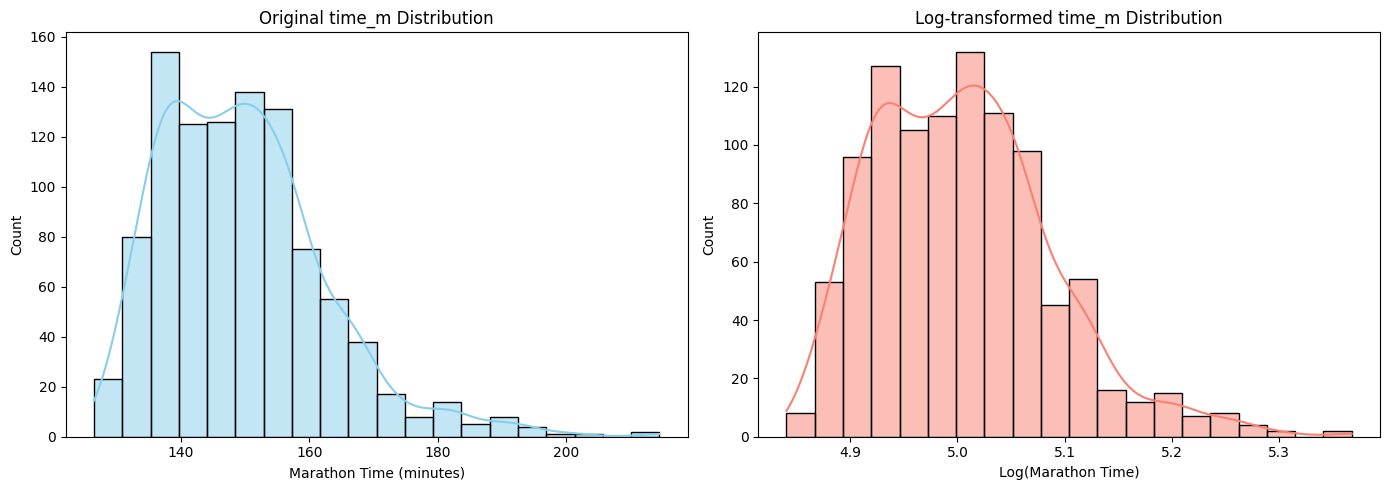

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Original time_m skewness:", df_raw9['time_m'].skew())
df_raw9['log_time_m'] = np.log(df_raw9['time_m'])
print("Log-transformed time_m skewness:", df_raw9['log_time_m'].skew())

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(df_raw9['time_m'], bins=20, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Original time_m Distribution")
axes[0].set_xlabel("Marathon Time (minutes)")

sns.histplot(df_raw9['log_time_m'], bins=20, kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Log-transformed time_m Distribution")
axes[1].set_xlabel("Log(Marathon Time)")

plt.tight_layout()
plt.show()


1. The log transform **reduces skewness slightly**, but the original distribution isn’t extreme.
2. For **linear regression**, `time_m` as-is is fine. Residuals are unlikely to be severely non-normal.

In [125]:
# log transform GNI, population and altitudes
df_raw9["gni_log"] = np.log(df_raw9["gni_per_capita"])
df_raw9["pop_log"] = np.log(df_raw9["population"])
# since there are legit zeros(sea-level)-> log(altitude+1)
df_raw9["alt_cn_log"] = np.log1p(df_raw9["country_altitude"]) 
df_raw9["alt_br_log"] = np.log1p(df_raw9["altitude"])

In [126]:
df_raw9.head(2)

,year,location,sex,rank,name,country,time,birthdate,birthplace,height,...,gni_per_capita,population,sex_dummy,age,bmi,log_time_m,gni_log,pop_log,alt_cn_log,alt_br_log
0,2020,Tokyo,female,1,Peres Jepchirchir,KEN,2-27:20,1993-09-27,"Turbo, Kenya",NaN,...,1910.0,52217334.0,1,27.0,18.4,4.992675,7.554859,17.770925,6.637258,7.545390
1,2020,Tokyo,female,2,Brigid Kosgei,KEN,2-27:36,1994-02-20,"Kapsowar, Elgeyo-Marakwet, Kenya",NaN,...,1910.0,52217334.0,1,26.0,18.4,4.994506,7.554859,17.770925,6.637258,7.739359



#### `log(x)`
* Standard natural log.
* Interpretation in regression: “A 1% increase in **x** changes the outcome by β% (approximately).”
* But you cannot take `log(0)` — undefined.

##### `log1p(x)` (≡ log(1 + x))
* Defined for `x = 0` (since `log(1+0)=0`).
* Interpretation: “A 1-unit increase in x (when x is small) changes the outcome by β units, but for larger x, it behaves like normal log.”

For **big values (like altitude = 2000m, 3000m, …)** → `log` and `log1p` are practically identical.


In [135]:
df_raw9.to_csv("8. Marathon_all.csv", index=False)

In [128]:
df_raw10 = df_raw9.copy()

In [129]:
df_raw10 = df_raw10[["year","sex_dummy","time_m","name","country","birth_country","age","bmi",
        "alt_br_log","alt_cn_log","gni_log","pop_log"]]
df_raw10.rename(columns={"time_m":"time","sex_dummy":"sex"}, inplace=True)

In [130]:
df_raw10.head(3)

,year,sex,time,name,country,birth_country,age,bmi,alt_br_log,alt_cn_log,gni_log,pop_log
0,2020,1,147.33,Peres Jepchirchir,KEN,KEN,27.0,18.4,7.545390,6.637258,7.554859,17.770925
1,2020,1,147.60,Brigid Kosgei,KEN,KEN,26.0,18.4,7.739359,6.637258,7.554859,17.770925
2,2020,1,147.77,Molly Seidel,USA,USA,26.0,19.1,5.605802,6.634633,11.081219,19.619373


In [131]:
df_raw10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           1005 non-null   int64  
 1   sex            1005 non-null   int64  
 2   time           1005 non-null   float64
 3   name           1005 non-null   object 
 4   country        1005 non-null   object 
 5   birth_country  1005 non-null   object 
 6   age            1005 non-null   float64
 7   bmi            1005 non-null   float64
 8   alt_br_log     1004 non-null   float64
 9   alt_cn_log     1004 non-null   float64
 10  gni_log        1004 non-null   float64
 11  pop_log        1004 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 94.3+ KB


In [134]:
df_raw9[df_raw9['alt_br_log'].isna()]

,year,location,sex,rank,name,country,time,birthdate,birthplace,height,...,gni_per_capita,population,sex_dummy,age,bmi,log_time_m,gni_log,pop_log,alt_cn_log,alt_br_log
88,2020,Tokyo,male,16,Tachlowini Gabriyesos,EOR,2-14:02,NaT,NaN,NaN,...,NaN,NaN,0,31.0,19.8,4.898064,NaN,NaN,NaN,NaN


Since EOR represents refuge, here it will be dropped.

In [136]:
df_raw10 = df_raw10.dropna(subset=['alt_br_log'])

In [137]:
df_raw10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 0 to 1004
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           1004 non-null   int64  
 1   sex            1004 non-null   int64  
 2   time           1004 non-null   float64
 3   name           1004 non-null   object 
 4   country        1004 non-null   object 
 5   birth_country  1004 non-null   object 
 6   age            1004 non-null   float64
 7   bmi            1004 non-null   float64
 8   alt_br_log     1004 non-null   float64
 9   alt_cn_log     1004 non-null   float64
 10  gni_log        1004 non-null   float64
 11  pop_log        1004 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 102.0+ KB


In [138]:
df_raw10.to_csv("9. Marathon_final.csv", index=False)

# Data is prepared for analysis!